In [1]:
'''
Test single network on dect dataset
'''

'\nTest single network on dect dataset\n'

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import os
import sys
import SimpleITK as sitk
import glob
import h5py
import configparser

In [4]:
sys.path.append('..')
import CTProjector.projector.ct_projector as ct_projector
import model.unet as unet

from decomposition import pad_projection_b

In [5]:
import argparse
import configparser
parser = argparse.ArgumentParser()
parser.add_argument('--prj', default = '/home/dwu/data/DECT/sinogram/sino_35_2.mat')
parser.add_argument('--energy', default = 'a')
parser.add_argument('--output', default = '/home/dwu/trainData/deep_denoiser_ensemble/test/dect_2d_3_layer_mean/debug_single/35')
parser.add_argument('--geometry', default = '/home/dwu/trainData/deep_denoiser_ensemble/data/dect_2d_3_layer_mean/geometry.cfg')
parser.add_argument('--islices', type = int, nargs = 2, default = [0,-1])
parser.add_argument('--nslice_mean', type = int, default=3)
# Note that 1e5 is for single slice noise insertion

parser.add_argument('--device', type = int, default = 0)
parser.add_argument('--img_norm', type = float, default = 0.019)
parser.add_argument('--train_dir', default = '/home/dwu/trainData/deep_denoiser_ensemble/train/mayo_2d_3_layer_mean/')
parser.add_argument('--checkpoint', default = 'l2_depth_3/all/5.h5')

parser.add_argument('--vmin', type=float, default = -0.16)
parser.add_argument('--vmax', type=float, default = 0.24)
# for single slice
parser.add_argument('--filter', default = 'hann')
parser.add_argument('--margin', type=int, default=96)

if sys.argv[0] != 'test2d_dect.py':
    showplot = True
    args = parser.parse_args(['--device', '0',
                              '--prj', '/home/dwu/data/DECT/sinogram/sino_35_2.mat',
                              '--energy', 'a',
                              '--islices', '90','92',
#                               '--tags', 'l2_depth_3_wgan/dose_rate_2,l2_depth_3_wgan/dose_rate_4,l2_depth_3_wgan/dose_rate_8,l2_depth_3_wgan/dose_rate_16',
                             ])
else:
    showplot = False
    args = parser.parse_args()

for k in vars(args):
    print (k, '=', getattr(args, k))

prj = /home/dwu/data/DECT/sinogram/sino_35_2.mat
energy = a
output = /home/dwu/trainData/deep_denoiser_ensemble/test/dect_2d_3_layer_mean/debug_single/35
geometry = /home/dwu/trainData/deep_denoiser_ensemble/data/dect_2d_3_layer_mean/geometry.cfg
islices = [90, 92]
nslice_mean = 3
device = 0
img_norm = 0.019
train_dir = /home/dwu/trainData/deep_denoiser_ensemble/train/mayo_2d_3_layer_mean/
checkpoint = l2_depth_3/all/5.h5
vmin = -0.16
vmax = 0.24
filter = hann
margin = 96


In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '%d'%args.device
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [7]:
print ('[Geometry]')
projector = ct_projector.ct_projector()
projector.from_file(args.geometry)
projector.nv = 1
for k in vars(projector):
    print (k, '=', getattr(projector, k))

[Geometry]
nview = 1152
nu = 736
nv = 1
nx = 640
ny = 640
nz = 1
dx = 0.75
dy = 0.75
dz = 1.0
cx = 0
cy = 0
cz = 0
dsd = 1086.5
dso = 595.0
du = 1.2858
dv = 1.0
off_u = 1.125
off_v = 0
geometry = <configparser.ConfigParser object at 0x2aac74b8edf0>


In [8]:
def get_slices(prj, args):
    if args.islices[0] < args.islices[1]:
        prj = np.copy(prj[args.islices[0] * args.nslice_mean:args.islices[1]*args.nslice_mean])
    else:
        prj = np.copy(prj[:prj.shape[0]//args.nslice_mean*args.nslice_mean])
    
    return prj.astype(np.float32)

In [9]:
print ('Loading data...', end='', flush=True)
with h5py.File(args.prj, 'r') as f:
    if args.energy == 'a':
        prj = get_slices(f['sinoA'], args)
    elif args.energy == 'b':
        prj_a = get_slices(f['sinoA'], args)
        prj_b = get_slices(f['sinoB'], args)
        prj = pad_projection_b(prj_a, prj_b)
    else:
        raise ValueError('args.energy must be either a or b, got %s'%args.energy)

print ('Done', flush=True)

# take layer-means
prj = prj.reshape([-1, args.nslice_mean, prj.shape[1], prj.shape[2]]).mean(1)
# reshape
prj = prj[:, :, np.newaxis, :] / args.img_norm

Loading data...Done


In [10]:
K.clear_session()
model = tf.keras.models.load_model(os.path.join(args.train_dir, args.checkpoint))

preds = []

print (len(prj), flush=True)
for islice in range(prj.shape[0]):
    print (islice, end=',', flush=True)
    
    angles = projector.get_angles()
    fprj = projector.ramp_filter(prj[[islice]], args.filter)
    fbp = projector.fbp_fan_bp(fprj, angles) - 1
    
    pred = model.predict(fbp[:, 0, :, :, np.newaxis])[..., 0]
    pred = pred[:, np.newaxis, :, :]
    
    preds.append(pred)    
print ('')

preds = np.array(preds)

2
0,1,


In [11]:
# save the results
print ('Writing results...', end='', flush=True)

if not os.path.exists(os.path.dirname(args.output)):
    os.makedirs(os.path.dirname(args.output))

output_name = args.output + '_' + args.energy
    
# running configuration
cfg = configparser.ConfigParser()
cfg.add_section('Test')
for k in vars(args):
    cfg['Test'][k] = str(getattr(args, k))
with open(output_name + '.cfg', 'w') as f:
    cfg.write(f)

# image
sitk_img = sitk.GetImageFromArray((preds.squeeze().transpose([0,2,1]) * 1000).astype(np.int16))
sitk_img.SetSpacing([float(projector.dx), float(projector.dy), float(projector.dz * args.nslice_mean)])
sitk.WriteImage(sitk_img, output_name + '.nii')

print ('Done', flush=True)

Writing results...Done


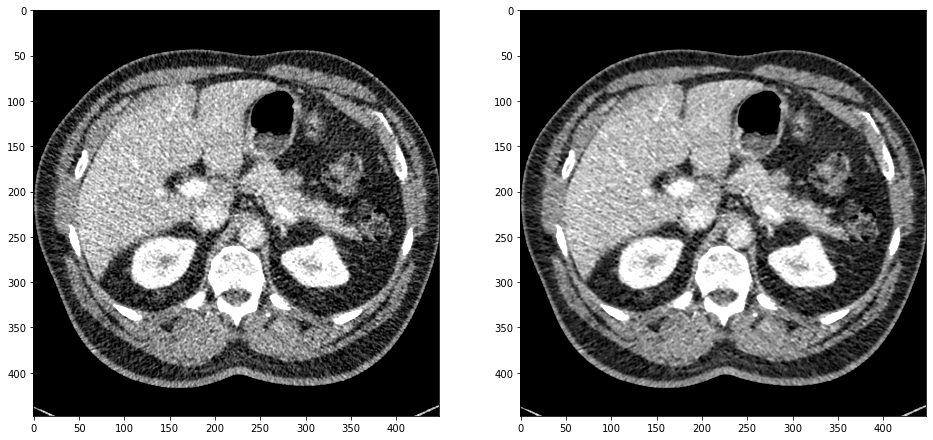

In [12]:
if showplot:
    plt.figure(figsize=[16,8])
    plt.subplot(121);plt.imshow(fbp[0,0,args.margin:-args.margin, args.margin:-args.margin].T, 'gray', vmin = args.vmin, vmax = args.vmax)
    plt.subplot(122);plt.imshow(pred[0,0,args.margin:-args.margin, args.margin:-args.margin].T, 'gray', vmin = args.vmin, vmax = args.vmax)